In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import numpy as np

from tqdm import tqdm
from datetime import timedelta
from sklearn.decomposition import NMF


In [2]:
tqdm.pandas()

In [4]:
billboard_hot_100 = pd.read_csv("../billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year

billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,year
0,1611,1959-01-12,The Chipmunks With David Seville,The Chipmunk Song,1,1.0,1,7,1959
1,1615,1959-01-05,The Chipmunks With David Seville,The Chipmunk Song,1,1.0,1,6,1959
2,1628,1959-01-12,The Platters,Smoke Gets In Your Eyes,2,2.0,2,9,1959
3,1629,1959-01-12,Connie Francis,My Happiness,3,6.0,3,6,1959
4,1630,1959-01-12,Billy Grammer,Gotta Travel On,4,9.0,4,8,1959


In [5]:
plt.rcParams.update({'font.size': 15})

In [6]:
billboard_hot_100["top_position"] = billboard_hot_100.groupby(
    ["artist", "song_name"])["position"].transform("min")

In [7]:
# concatenate artist and song name
billboard_hot_100["artist_song"] = billboard_hot_100["artist"] + " - " +\
    billboard_hot_100["song_name"]
billboard_hot_100["first_week"] = billboard_hot_100.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("min")
billboard_hot_100["last_week"] = billboard_hot_100.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("max")
billboard_hot_100["start_end_week_diff"] = (billboard_hot_100["last_week"] - billboard_hot_100["first_week"]).dt.days / 7

In [8]:
min_first_week = billboard_hot_100["first_day_of_the_week"].min().to_pydatetime()
billboard_hot_100["first_day_of_the_week_copy"] = billboard_hot_100["first_day_of_the_week"]
billboard_hot_100["first_day_of_the_week"] = billboard_hot_100.progress_apply(lambda row:
            int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

100%|██████████| 333887/333887 [00:07<00:00, 42965.50it/s]


In [9]:
billboard_hot_100 = billboard_hot_100[billboard_hot_100["start_end_week_diff"] <= 100]

pv_table = billboard_hot_100[billboard_hot_100["start_end_week_diff"] <= 100].pivot_table(index="first_day_of_the_week",
        columns="artist_song", values="position", fill_value=101)

In [10]:
pv_table

artist_song,"""Groove"" Holmes - Misty","""Groove"" Holmes - What Now My Love","""Little"" Jimmy Dickens - May The Bird Of Paradise Fly Up Your Nose","""Pookie"" Hudson - I Know I Know","""Weird Al"" Yankovic - Amish Paradise","""Weird Al"" Yankovic - Canadian Idiot","""Weird Al"" Yankovic - Eat It","""Weird Al"" Yankovic - Fat","""Weird Al"" Yankovic - I Lost On Jeopardy","""Weird Al"" Yankovic - King Of Suede",...,twenty one pilots - Stressed Out,twenty one pilots - Tear In My Heart,will.i.am & Britney Spears - Scream & Shout,will.i.am & Nicki Minaj - Check It Out,will.i.am - I Got It From My Mama,will.i.am - It's A New Day,will.i.am Featuring Justin Bieber - #thatPOWER,will.i.am Featuring Mick Jagger & Jennifer Lopez - T.H.E (The Hardest Ever),will.i.am Featuring Miley Cyrus - Fall Down,"will.i.am Featuring Miley Cyrus, French Montana, Wiz Khalifa & DJ Mustard - Feelin' Myself"
first_day_of_the_week,,,,,,,,,,,,,,,,,,,,,
0,100,98,90,96,65,82,59,99,83,77,...,87,82,12,78,93,78,42,36,58,96
1,85,98,75,101,62,94,36,100,81,66,...,101,101,13,57,57,101,60,90,101,99
2,84,96,59,101,58,98,18,101,97,62,...,101,101,15,42,32,101,65,101,101,101
3,82,101,43,101,53,101,14,101,101,62,...,97,101,12,50,31,101,60,101,101,101
4,64,101,29,101,53,101,13,101,101,91,...,101,101,12,34,33,101,43,101,101,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101
97,101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101
98,101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101


In [11]:
nmf = NMF(n_components=6, init='random', random_state=0)
nmf.fit(pv_table)

c:\Users\cutie\source\repos\mgr\env\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(init='random', n_components=6, random_state=0)

In [12]:
nmf_features = nmf.transform(pv_table)

In [13]:
def display_components(model, song_names, num_top_positions):
    # iterate through topics in topic-term matrix, 'H' aka
    # model.components_
    for ix, archetype in enumerate(model.components_):
        #print topic, topic number, and top words
        print("\nArchetype ", ix)
        print(", ".join([song_names[i] \
             for i in archetype.argsort()[:-num_top_positions - 1:-1]]))

In [14]:
display_components(nmf, billboard_hot_100["artist_song"].values, 5)


Archetype  0
Bob Beckham - Just As Much As Ever, The Beach Boys - Little Deuce Coupe, Billy Grammer - The Kissing Tree, Connie Stevens - Sixteen Reasons, Johnny Mathis - Your Teenage Dreams

Archetype  1
Gary U.S. Bonds - School Is Out, Thelma Carpenter - Yes, I'm Lonesome Tonight, Quaker City Boys - Teasin', Steve Lawrence - Pretty Blue Eyes, Steve Lawrence - Footsteps

Archetype  2
Doris Troy - Just One Look, Dion - Havin' Fun, Al Casey - Surfin' Hootenanny, Mel Torme - Comin' Home Baby, The Everly Brothers - Crying In The Rain

Archetype  3
Herb Alpert And Tijuana Brass - The Lonely Bull (El Solo Torro), The Highwaymen - Michael, Dick and DeeDee - Young And In Love, Bobby Rydell - I Wanna Thank You, Joe Damiano - I Cried

Archetype  4
Sam Cooke - Frankie And Johnny, Joni James - I Still Get A Thrill (Thinking Of You), Jackie Wilson - You Don't Know What It Means, Paul Anka - Every Night (Without You), Ricky Nelson - Never Be Anyone Else But You

Archetype  5
Paul Anka - Remember Di

In [15]:
# Create a DataFrame: components_df
components_df = pd.DataFrame(nmf.components_, columns=billboard_hot_100["artist_song"].drop_duplicates().values)
components_df

,The Chipmunks With David Seville - The Chipmunk Song,The Platters - Smoke Gets In Your Eyes,Connie Francis - My Happiness,Billy Grammer - Gotta Travel On,"The Teddy Bears - To Know Him, Is To Love Him",Fats Domino - Whole Lotta Loving,Clyde McPhatter - A Lover's Question,Elvis Presley - One Night,The Everly Brothers - Problems,Ricky Nelson - Lonesome Town,...,SZA Featuring Travis Scott - Open Arms,SZA - Smoking On My Ex Pack,SZA - F2F,Juice WRLD - Face 2 Face,Pentatonix Featuring Meghan Trainor - Kid On Christmas,SZA - Conceited,SZA - Far,SZA - Too Late,SZA Featuring Ol' Dirty Bastard - Forgiveless,A Boogie Wit da Hoodie Featuring Kodak Black - Water (Drowning Pt. 2)
0,5.905477,4.343974,3.381420,4.460582,3.355208,4.038370,0.861822,4.487419,3.781217,2.079924,...,3.091784,4.317446,0.000000,4.288865,0.484467,4.527160,6.851310,4.878323,3.847467,4.419601
1,4.492695,4.340771,4.566335,4.388748,2.040518,3.733532,1.910828,4.469058,3.492334,2.483519,...,0.000000,3.812429,4.064588,2.704685,3.372425,3.595331,0.596260,2.389533,3.095991,4.346841
2,1.321902,1.923395,3.171843,1.835667,3.443579,2.277406,5.507104,1.796182,2.502183,3.929370,...,1.565945,2.027782,6.822521,2.973459,5.052237,1.998627,1.641892,2.300351,2.572444,1.871879
3,2.110433,4.955624,0.539384,4.990140,2.467530,5.026872,0.311418,4.976533,5.002648,4.484440,...,5.472940,5.076620,0.042970,0.765182,2.219875,5.062990,0.929525,3.958253,5.148636,4.987839
4,1.204512,2.015440,4.202386,1.840957,5.926171,2.788529,9.046223,1.755807,3.262951,6.007127,...,0.000000,2.513688,9.123000,4.897285,7.649515,2.400001,4.427514,3.311150,3.438660,1.919013
5,3.575316,4.208023,4.971973,4.159878,3.959488,4.244704,5.677665,4.161164,4.323800,4.985910,...,4.818926,3.959694,0.000000,3.810813,6.069485,3.937783,1.252460,3.642937,4.222431,4.171721


In [16]:
# get all artist-songs for archetypes
archetypes = {i: [] for i in range(6)}
for artist_song in components_df.columns:
    archetype = components_df[artist_song].argmax()
    archetypes[archetype].append(artist_song)


In [17]:
nmf_features_pd = pd.DataFrame(nmf_features)

nmf_features_pd

,0,1,2,3,4,5
0,8.094220,9.108304,1.203816,0.124922,0.959919,3.486245
1,6.661209,6.534390,1.013077,7.253557,0.134939,1.110566
2,5.170122,4.556161,0.679904,11.376882,0.000000,0.000000
3,3.883714,2.962484,0.257520,13.947004,0.000000,0.000000
4,2.832811,1.547829,0.105719,16.228249,0.000000,0.000000
...,...,...,...,...,...,...
96,9.221730,4.948363,5.099695,2.593951,5.038625,1.594714
97,9.221736,4.947894,5.100025,2.594924,5.038597,1.593803
98,9.221516,4.947544,5.099762,2.595373,5.038994,1.593665
99,9.221361,4.947351,5.099646,2.595615,5.039208,1.593594


In [18]:
approx_song_i = np.matmul(nmf_features_pd, components_df.values[:, 54])

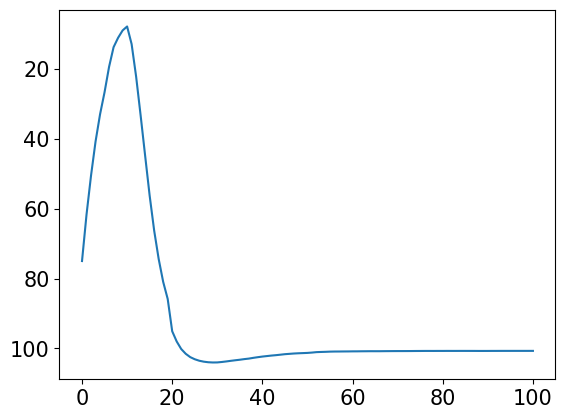

In [19]:
plt.plot(range(0, 101), approx_song_i)
plt.gca().invert_yaxis()
plt.show()

In [20]:
rows_to_add = []

grouped = billboard_hot_100.groupby(["artist", "song_name"])

for name, group in tqdm(grouped):
    max_week = group["first_day_of_the_week"].max()

    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            week = row["first_day_of_the_week"] + 1

            while week <= 101:
                rows_to_add.append({
                    "artist_song": row["artist_song"],
                    "weeks_on_chart": row["weeks_on_chart"],
                    "position": 101,
                    "first_day_of_the_week": week,
                    "top_position": row["top_position"],
                    "first_week": row["first_week"]
                })
                week += 1

billboard_100_with_empty_weeks = pd.concat([billboard_hot_100[["artist_song",
    "weeks_on_chart", "position", "first_day_of_the_week", "first_week", "top_position"]], pd.DataFrame(rows_to_add)], ignore_index=True)

100%|██████████| 29984/29984 [01:01<00:00, 490.65it/s]


6it [00:35,  5.87s/it]


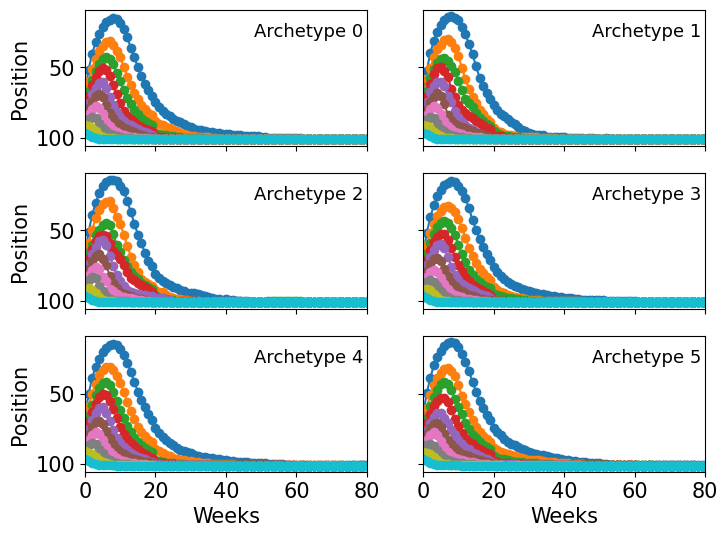

In [32]:
# plot all trajectories of archetypes
fig, axes = plt.subplots(int(len(nmf.components_)/2), 2, figsize=(8, 6), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for top_position in range(10, 110, 10):
        songs_ids_from_archetype = archetypes[ix]
        songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        songs_from_archetype = songs_from_archetype[(songs_from_archetype["top_position"] <= top_position) &\
            (songs_from_archetype["top_position"] > top_position - 10)][["artist_song"]]
        songs_from_archetype = songs_from_archetype[["artist_song"]].drop_duplicates().merge(
            billboard_100_with_empty_weeks[["artist_song",
                "position", "first_day_of_the_week", "first_week"]], on=["artist_song"], how="left")
        axes[row_i, col_i].plot(songs_from_archetype.groupby("first_day_of_the_week")["position"].mean(),
            marker='o')
        
    #axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].text(0.6, 0.8, f"Archetype {ix}", transform=axes[row_i, col_i].transAxes, fontsize=13)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Weeks")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.xlim(0, 80)
plt.gca().invert_yaxis()
plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1264.91it/s]
6it [00:10,  1.67s/it]


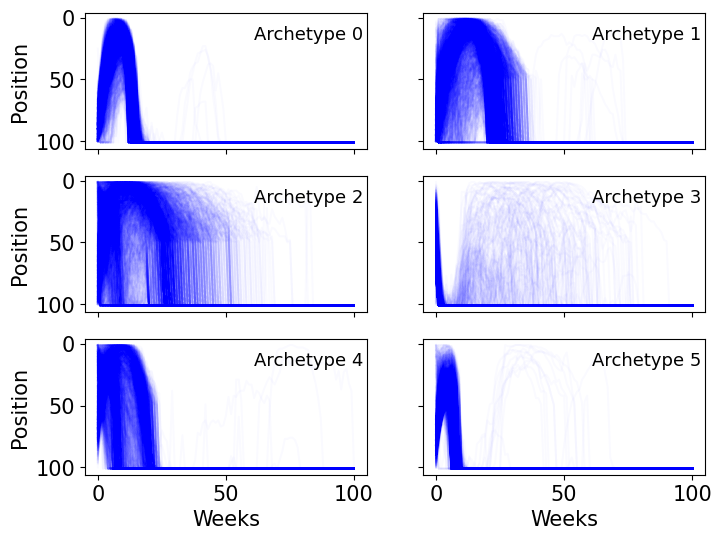

In [34]:
fig, axes = plt.subplots(int(len(nmf.components_)/2), 2, figsize=(8, 6), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for i in tqdm(archetype.argsort()[:-2000 - 1:-1]):
        # songs_ids_from_archetype = archetypes[ix]
        # songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        trajectory = pv_table.iloc[:, i].values
        #trajectory = trajectory[trajectory != 101]
        axes[row_i, col_i].plot(trajectory, alpha=0.02, color="blue")
    
    #axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].text(0.6, 0.8, f"Archetype {ix}", transform=axes[row_i, col_i].transAxes, fontsize=13)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Weeks")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")


    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.gca().invert_yaxis()
plt.savefig("figures/cluster_trajectories_nmf.pdf", format="pdf", bbox_inches="tight")
plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1083.48it/s]
6it [00:13,  2.20s/it]


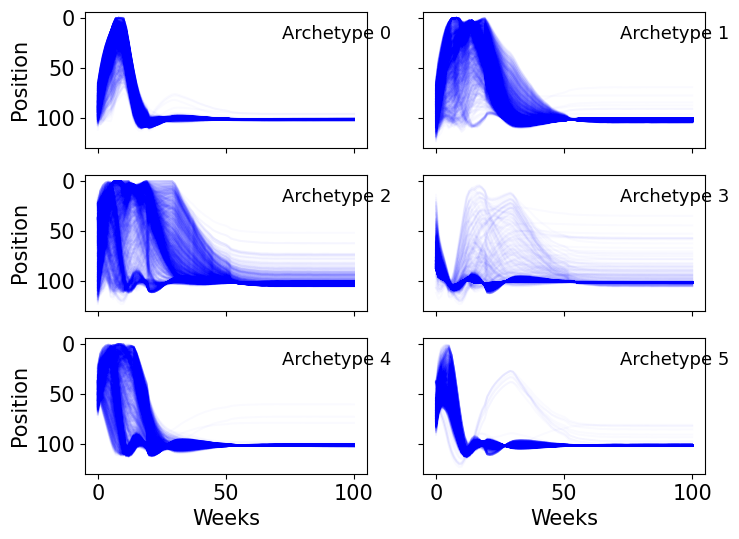

In [33]:
fig, axes = plt.subplots(int(len(nmf.components_)/2), 2, figsize=(8, 6), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for i in tqdm(archetype.argsort()[:-2000 - 1:-1]):
        # songs_ids_from_archetype = archetypes[ix]
        # songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        trajectory = np.matmul(nmf_features_pd, components_df.values[:, i])
        trajectory = trajectory[trajectory != 101]
        axes[row_i, col_i].plot(trajectory, alpha=0.02, color="blue")
    
    #axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].text(0.7, 0.8, f"Archetype {ix}", transform=axes[row_i, col_i].transAxes, fontsize=13)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Weeks")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")


    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.gca().invert_yaxis()
plt.show()

In [24]:
billboard_hot_100["archetype"] = billboard_hot_100["artist_song"].progress_apply(lambda x: components_df[x].argmax())


100%|██████████| 330249/330249 [00:13<00:00, 24236.94it/s]


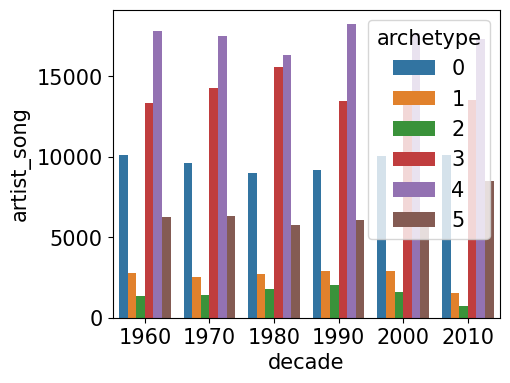

In [30]:
import seaborn as sns

plt.figure(figsize=(5, 4))

billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week_copy"].dt.year
billboard_hot_100["decade"] = billboard_hot_100["year"].apply(lambda x: x - x % 10)
counts = billboard_hot_100[["archetype", "decade", "artist_song"]].groupby(["archetype", "decade"]).count().reset_index()
counts = counts[(counts["decade"] != 2020) & (counts["decade"] != 1950)]
sns.barplot(counts, x="decade", y="artist_song", hue="archetype")

plt.show()